In [72]:
import numpy as np

import pandas as pd

from collections import defaultdict

import keras
import keras.backend as K
from keras.layers import Dense, GlobalAveragePooling1D, Embedding
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/train.zip
/kaggle/input/sample_submission.zip
/kaggle/input/test.zip


In [73]:
from zipfile import ZipFile
with ZipFile('/kaggle/input/train.zip', 'r') as zipObj: zipObj.extractall()
with ZipFile('/kaggle/input/test.zip', 'r') as zipObj: zipObj.extractall()
with ZipFile('/kaggle/input/sample_submission.zip', 'r') as zipObj: zipObj.extractall()

In [74]:
train = pd.read_csv('/kaggle/working/train.csv')
test  = pd.read_csv('/kaggle/working/test.csv')
sub   = pd.read_csv('/kaggle/working/sample_submission.csv')

display(train.head())
display(test.head())
display(sub.head())

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [75]:
auth_label = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
trainY = np.array([auth_label[a] for a in train.author])
trainY = to_categorical(trainY)

In [76]:
trainY

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

# **Let's check character distribution per author**

In [77]:
counter = {name : defaultdict(int) for name in set(train.author)}

# Letter frequency
for (text, author) in zip(train.text, train.author):
    text = text.replace(' ', '')
    for c in text:
        counter[author][c] += 1
#display(counter)

char_num = pd.DataFrame.from_dict(counter, orient='index')
char_num = char_num.fillna(0)

from IPython.core.display import HTML
display(char_num)
#display(HTML(char_num.T.to_html()))

,H,o,w,l,v,e,y,i,s,p,...,Æ,ἶ,δ,α,à,è,â,î,ô,ç
MWS,669,53386,16062,27819,7948,97515,14877,46080,45962,12361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HPL,741,50996,15554,30273,6529,88259,12534,44250,43915,10965,...,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
EAP,864,67145,17507,35371,9624,114885,17001,60952,53841,17422,...,1.0,0.0,0.0,0.0,10.0,15.0,6.0,1.0,8.0,1.0


# **Preprocessing**

My preproceeings are 

- Separate punctuation from words
- Cut a longer document which contains `256` words

... Trial
- stemming
- lemmatization
- removing stopwords

none of above make results better ^^;

In [98]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


def preprocess(text):
    
    # -- seperate punctuation from words
    signs = set(string.punctuation) # or just set(',.:;"?!') which are only used
    prods = set(text) & signs # punctuations in text
    if not prods: return text
    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign) )
    
    '''
    # -- removing stopwords
    text = text.lower()
    stopwords = nltk.corpus.stopwords.words('english')
    text = word_tokenize(text)
    removed_text = []
    for word in text:
        if word not in stopwords: removed_text.append(word)
    text = ' '.join(removed_text)
    
    # -- Lemmatization
    text = word_tokenize(text)
    lemm = WordNetLemmatizer()
    lem_text = [lemm.lemmatize(words) for words in text]
    text = ' '.join(lem_text)
    
    # -- Stemming
    text = word_tokenize(text)
    stemm = PorterStemmer()
    stem_text = [stemm.stem(words) for words in text]
    text = ' '.join(stem_text)
    '''
    
    return text


# -- Make ngrams
n_gram_max = 2
def add_ngram(words):
    ngrams = []
    for n in range(2, n_gram_max+1):
        for w_index in range(len(words)-n+1):
            ngrams.append(' '.join(words[w_index:w_index+n]))
        #print(ngrams)
    return words + ngrams


def create_docs(train):
    docs = []
    for doc in train.text:
        doc = preprocess(doc).split()
        docs.append(' '.join(add_ngram(doc)))
    return docs

In [99]:
min_count = 1 # == word's min frequency

docs = create_docs(train)
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(docs)
num_words = sum([1 for _, count in tokenizer.word_counts.items() if count >= min_count])

# Vectorization
tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(docs)
docs = tokenizer.texts_to_sequences(docs)

# Choose features (crop text)
maxlen = 256
docs = pad_sequences(sequences=docs, maxlen=maxlen)

# **2. Model: FastText by Keras**

FastText is very fast and strong baseline algorithm for text classification based on Continuous Bag-of-Words model a.k.a Word2vec.

FastText contains only three layers:

1. Embeddings layer: Input words (and word n-grams) are all words in a sentence/document
2. Mean/AveragePooling Layer: Taking average vector of Embedding vectors
3. Softmax layer

There are some implementations of FastText:

- Original library provided by Facebook AI research: https://github.com/facebookresearch/fastText
- Keras: https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py
- Gensim: https://radimrehurek.com/gensim/models/wrappers/fasttext.html

Original Paper: https://arxiv.org/abs/1607.01759 : More detail information about fastText classification model

# Use GridSearchCV to find out best parameters

In [ ]:
#Finding optimizer, activation, output_dim
from sklearn.model_selection import GridSearchCV

from keras.layers import Conv2D,Dense,MaxPool2D,Dropout,Flatten
from keras.models import Sequential
import cv2
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

input_dim = np.max(docs) + 1

def create_cnn(optimizer, activation, output_dim):
    
    model = Sequential()
    model.add(Embedding(input_dim, output_dim))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3, activation=activation))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

x_train, x_test, y_train, y_test = train_test_split(docs, trainY, test_size=0.2)
cnn = KerasClassifier(build_fn=create_cnn)

param_grid ={
    #'epochs': [10, 25, 50],
    #'batch_size': [1, 10, 50],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'elu', 'softmax'],
    'output_dim': [200, 100, 20]
}

cnn = KerasClassifier(build_fn=create_cnn, verbose=1)
cnn = GridSearchCV(cnn, param_grid, verbose=1, cv=3, n_jobs=-1)

#cnn.fit(x_train,y_train)
hist = cnn.fit(x_train, y_train,
        validation_data=(x_test, y_test), epochs=50, batch_size=50,
        callbacks=[EarlyStopping(patience=3, monitor='val_loss')])

print(cnn.best_params_)
print(cnn.score(x_test, y_test))


In [ ]:
# Find out epochs and batch_size
from sklearn.model_selection import GridSearchCV

from keras.layers import Conv2D,Dense,MaxPool2D,Dropout,Flatten
from keras.models import Sequential
import cv2
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

input_dim = np.max(docs) + 1
embedding_dims = 20

def create_cnn():
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2)) ##
    model.add(Dense(10, activation='relu')) ##
    model.add(Dropout(0.2)) ##
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

x_train, x_test, y_train, y_test = train_test_split(docs, trainY, test_size=0.2)
cnn = KerasClassifier(build_fn=create_cnn)

param_grid ={
    'epochs': [10, 25, 50],
    'batch_size': [1, 10, 50],
    #,'optimizer': ['Adam', 'Nadam']
    #,'dropout_rate': [0.1, 0.2, 0.5]
    #,'activation': ['relu', 'elu', 'softmax']
}


cnn = GridSearchCV(cnn, param_grid, verbose=1, cv=3, n_jobs=-1)
cnn.fit(x_train, y_train,validation_data=(x_test, y_test),
        callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

print(cnn.best_params_)
print(cnn.score(x_test, y_test))


# Use Best model !!

In [100]:
input_dim = np.max(docs) + 1
embedding_dims = 20

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model


epochs = 50
x_train, x_test, y_train, y_test = train_test_split(docs, trainY, test_size=0.2)

model = create_model()

hist = model.fit(x_train, y_train, batch_size=50,
                 validation_data=(x_test, y_test),
                 epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Epoch 1/50
314/314 [==============================] - 3s 8ms/step - loss: 1.0723 - accuracy: 0.4067 - val_loss: 1.0471 - val_accuracy: 0.4183
Epoch 2/50
314/314 [==============================] - 2s 8ms/step - loss: 0.9906 - accuracy: 0.5065 - val_loss: 0.9377 - val_accuracy: 0.5917
Epoch 3/50
314/314 [==============================] - 2s 8ms/step - loss: 0.8579 - accuracy: 0.6844 - val_loss: 0.8140 - val_accuracy: 0.6854
Epoch 4/50
314/314 [==============================] - 2s 8ms/step - loss: 0.7342 - accuracy: 0.7585 - val_loss: 0.7174 - val_accuracy: 0.7487
Epoch 5/50
314/314 [==============================] - 2s 8ms/step - loss: 0.6394 - accuracy: 0.7948 - val_loss: 0.6488 - val_accuracy: 0.7740
Epoch 6/50
314/314 [==============================] - 2s 8ms/step - loss: 0.5668 - accuracy: 0.8184 - val_loss: 0.5979 - val_accuracy: 0.7860
Epoch 7/50
314/314 [==============================] - 2s 8ms/step - loss: 0.5094 - accuracy: 0.8387 - val_loss: 0.5581 - val_accuracy: 0.7965
Epoch 

In [101]:
print(model.evaluate(x_test, y_test))

model.save("original.h5")

"""
from tensorflow.keras.models import load_model
model = load_model("model_name.h5")
"""

123/123 [==============================] - 0s 3ms/step - loss: 0.3854 - accuracy: 0.8506
[0.3854089677333832, 0.8506128787994385]


'\nfrom tensorflow.keras.models import load_model\nmodel = load_model("model_name.h5")\n'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


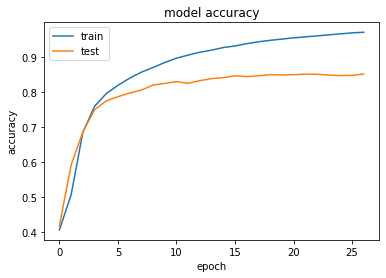

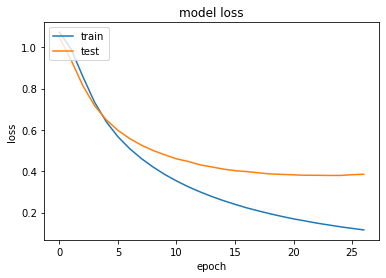

In [102]:
print(hist.history.keys())

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



# Save Results

In [103]:
docs = create_docs(test)
docs = tokenizer.texts_to_sequences(docs)
docs = pad_sequences(sequences=docs, maxlen=maxlen)

result = model.predict_proba(docs)

In [104]:
for a, i in auth_label.items():
    sub[a] = result[:, i]
 
sub.to_csv('fastText_result_original.csv', index=False)

In [105]:
sub.loc[0]

id        id02310
EAP     0.0742014
HPL    0.00149586
MWS      0.924303
Name: 0, dtype: object